In [3]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [4]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [5]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

def voigt(f, f0, a, sigma, gamma, c):
    v = voigt_profile(f-f0, sigma, gamma)
    return a*v/(np.abs(np.max(v))) + c

def get_voigt_fit(detunings, voltages):
    fitter = Fitter(voigt)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f0": 0, "a": -0.16, "c": 1, "sigma": 0.6, "gamma": 0.2})
    fitter.fit()
    

    return fitter

In [20]:
def group_and_average_data(data, cycles):
    total_cycles = sum(cycles.values())
    remainder_to_label = {}
    for kk in range(total_cycles):
        last_index_of_label = 0
        for label in cycles:
            last_index_of_label += cycles[label]
            if kk < last_index_of_label:
                remainder_to_label[kk] = label
                break
    data_averages = {}
    for label in cycles:
        data_averages[label] = []
    for kk in range(len(data)):
        remainder = kk % total_cycles
        data_averages[remainder_to_label[remainder]].append(data[kk])
    for label in cycles:
        data_averages[label] = np.average(data_averages[label], axis=0)
    return data_averages

In [21]:
def rf_spectroscopy(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["detuning"].to("kHz").magnitude
        offsets.append(offset)
        transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, transmissions_avg["antihole"]/transmissions_avg["chasm"], p0={"sigma": 0.3})
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, transmissions_avg["rf"]/transmissions_avg["chasm"], p0={"sigma": 0.3})
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    offsets = np.array(offsets)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = offsets
    ys = ratios
    return xs, ys

In [5]:
def rf_spectroscopy_field(data_list):
    positive_antihole_heights = []
    positive_antihole_height_errs = []
    negative_antihole_heights = []
    negative_antihole_height_errs = []
    positive_rf_heights = []
    positive_rf_height_errs = []
    negative_rf_heights = []
    negative_rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["probe_offset"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        positive_mask = detunings > 0
        positive_antihole_fit = get_gaussian_fit(detunings[positive_mask], antihole_avg[positive_mask]/chasm_avg[positive_mask], p0={"f_0": 2, "a": -0.1, "c": 1, "sigma": 0.3})
        positive_antihole_heights.append(positive_antihole_fit.results["a"])
        positive_antihole_height_errs.append(positive_antihole_fit.errors["a"])
        
        positive_rf_fit = get_gaussian_fit(detunings[positive_mask], rf_avg[positive_mask]/chasm_avg[positive_mask], p0={"f_0": 2, "a": -0.1, "c": 1, "sigma": 0.3})
        positive_rf_heights.append(positive_rf_fit.results["a"])
        positive_rf_height_errs.append(positive_rf_fit.errors["a"])
    
        negative_mask = detunings < 0
        negative_antihole_fit = get_gaussian_fit(detunings[negative_mask], antihole_avg[negative_mask]/chasm_avg[negative_mask], p0={"f_0": -2, "a": -0.1, "c": 1, "sigma": 0.3})
        negative_antihole_heights.append(negative_antihole_fit.results["a"])
        negative_antihole_height_errs.append(negative_antihole_fit.errors["a"])
        
        negative_rf_fit = get_gaussian_fit(detunings[negative_mask], rf_avg[negative_mask]/chasm_avg[negative_mask], p0={"f_0": -2, "a": -0.1, "c": 1, "sigma": 0.3})
        negative_rf_heights.append(negative_rf_fit.results["a"])
        negative_rf_height_errs.append(negative_rf_fit.errors["a"])

    offsets = np.array(offsets)
    positive_antihole_heights = np.array(positive_antihole_heights)
    positive_antihole_height_errs = np.array(positive_antihole_height_errs)
    negative_antihole_heights = np.array(negative_antihole_heights)
    negative_antihole_height_errs = np.array(negative_antihole_height_errs)
    positive_rf_heights = np.array(positive_rf_heights)
    positive_rf_height_errs = np.array(positive_rf_height_errs)
    negative_rf_heights = np.array(negative_rf_heights)
    negative_rf_height_errs = np.array(negative_rf_height_errs)
    positive_ratios = positive_rf_heights / positive_antihole_heights
    positive_ratio_errs = positive_ratios * np.sqrt((positive_rf_height_errs / positive_rf_heights) ** 2 + (positive_antihole_height_errs / positive_antihole_heights) ** 2)
    negative_ratios = negative_rf_heights / negative_antihole_heights
    negative_ratio_errs = negative_ratios * np.sqrt((negative_rf_height_errs / negative_rf_heights) ** 2 + (negative_antihole_height_errs / negative_antihole_heights) ** 2)

    xs = offsets
    positive_ys = positive_ratios
    negative_ys = negative_ratios
    return xs, positive_ys, negative_ys
    

In [6]:
def rf_flopping(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    times = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        times.append(headers["params"]["rf"]["duration"].to("ms").magnitude)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg, p0={"sigma": 0.5})
        # antihole_fit = get_voigt_fit(detunings, antihole_avg/chasm_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])

        # REMOVE:
        # antihole_line = antihole_avg/chasm_avg
        # antihole_heights.append(np.abs(np.max(antihole_line) - np.min(antihole_line)))

        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg, p0={"sigma": 0.5})
        # rf_fit = get_voigt_fit(detunings, rf_avg/chasm_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

        # REMOVE:
        # rf_line = rf_avg/chasm_avg
        # rf_heights.append(np.abs(np.max(rf_line) - np.min(rf_line)))
    
    times = np.array(times)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)


    

    xs = times
    ys = ratios
    return xs, ys
    

In [31]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

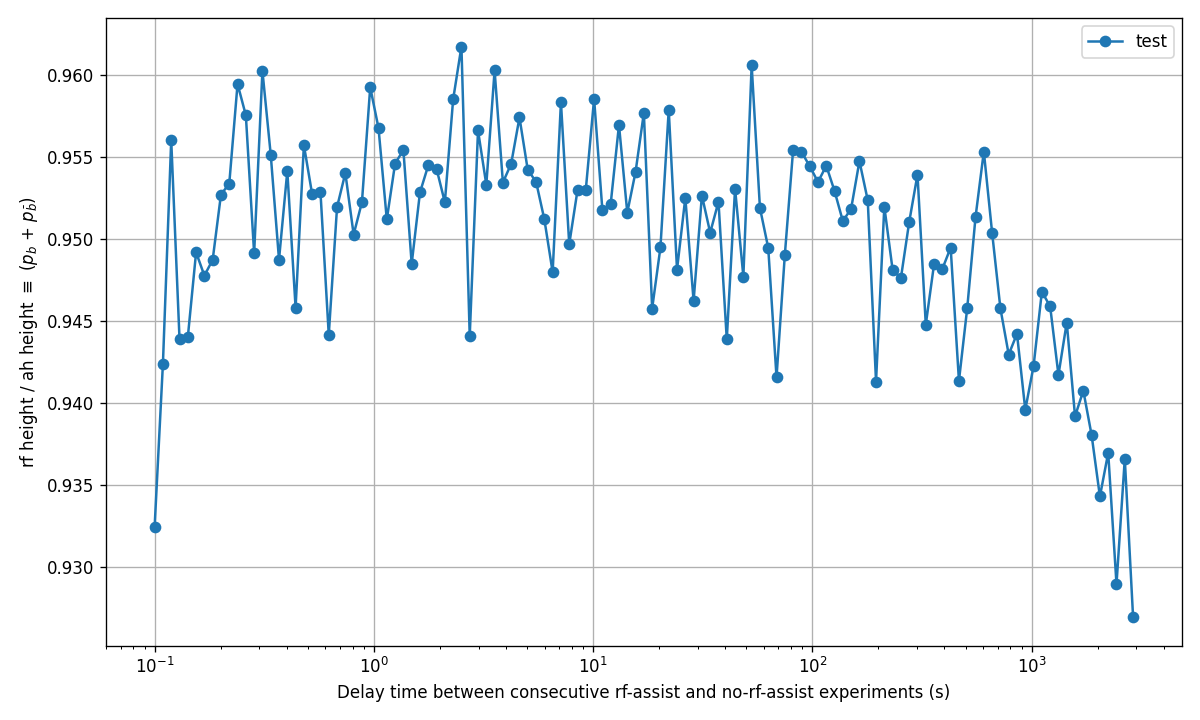

In [8]:
data = {
    #"0.3 s antihole": (54862, 54961),
    #"0.03 s antihole": (54962, 55061),
    #"0.3 s antihole 1": (55094, 55103),
    #"0.03 s antihole 1": (55104, 55113),
    #"0.03 s antihole 2": (55114, 55123),
    #"0.3 s antihole 2": (55124, 55133),
    #"1 s antihole, -46 kHz, 3": (55134, 55143),
    #"0.03 s antihole, 100 kHz, 3": (55144, 55153),
    #"1 s antihole, -46 kHz 4": (55154, 55163),
    #"0.03 s antihole, 100 kHz, 4": (55164, 55173),
    #"1 s antihole, -46 kHz 5": (55174, 55183),
    #"0.03 s antihole, 100 kHz, 5": (55184, 55193),
    #"1 s antihole, -46 kHz 6": (55194, 55203),
    #"0.03 s antihole, -46 kHz, 6": (55204, 55213),
    
    # "1 s antihole, -46 kHz 7": (55214, 55223),
    # "0.03 s antihole, -46 kHz, 7": (55224, 55233),
    # "0.03 s antihole, -46 kHz, 8": (55234, 55243),
    # "1 s antihole, -46 kHz, 9": (55273, 55282),
    # "0.03 s antihole, -46 kHz, 1.94 s wait, 9": (55283, 55292),
    # "1 s antihole, -46 kHz, 10": (55293, 55302),
    # "0.03 s antihole, -46 kHz, 10": (55303, 55312),
    # "1 s antihole, -46 kHz, 10 s wait, 11": (55313, 55322),
    # "0.03 s antihole, -46 kHz, 10 s wait, 11": (55323, 55332),
    # "1 s antihole, -46 kHz, wide scan, 12": (55333, 55342),

    # "0.03 s antihole -46 kHz": (55940, 55949),
    # "1 s antihole -46 kHz": (55950, 55959),

    # temperature dependence
    # "": (56674, 56863),

    "test": [kk for kk in range(73794, 74033) if kk % 2 == 1],
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)

temps = {
    56689 : 7.4,
    56699 : 8.2,
    56719 : 9.5,
    56749 : 11,
    56759 : 11.6,
    56779 : 12.8,
    56799 : 14.1,
    56809 : 13.2,
    56829 : 4.5,
}

delay_times = np.logspace(-1, 3.5, 120)

for label, identification in data.items():
    data_list = data_identification_to_list(identification)
    data_indices = []
    heights = []
    
    for kk in data_list:
        xs, ys = rf_flopping([kk])
        data_indices.append(kk - data_list[0])
        heights.append(ys[0])
        if kk in temps:
            # ax.plot([kk - data_list[0]]*2, [0.9*ys[0], 1.1*ys[0]], '-', color="C1")
            ax.text(kk - data_list[0], 0.95*ys[0], f"{temps[kk]:.1f} K", color="C1")
    ax.semilogx(delay_times[:len(heights)], heights, 'o-', label = label)
    
ax.set_xlabel("Delay time between consecutive rf-assist and no-rf-assist experiments (s)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
    
plt.tight_layout()
plt.grid()
plt.show()

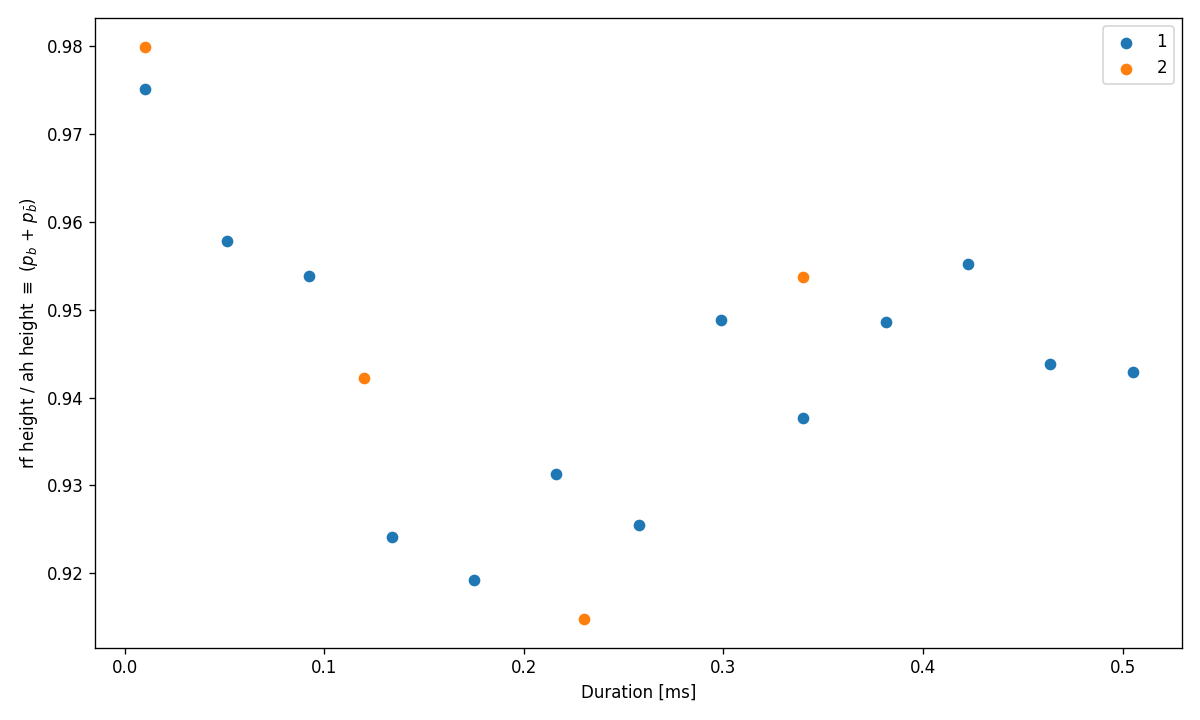

In [57]:
data = {
    "1": (101980, 101992),
    "2": (102455, 102458),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)

for label, identification in data.items():
    data_list = data_identification_to_list(identification)
    xs, ys = rf_flopping(data_list)
    ax.scatter(xs, ys, label = label)
    
ax.set_xlabel("Duration [ms]")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
    
plt.tight_layout()
plt.show()

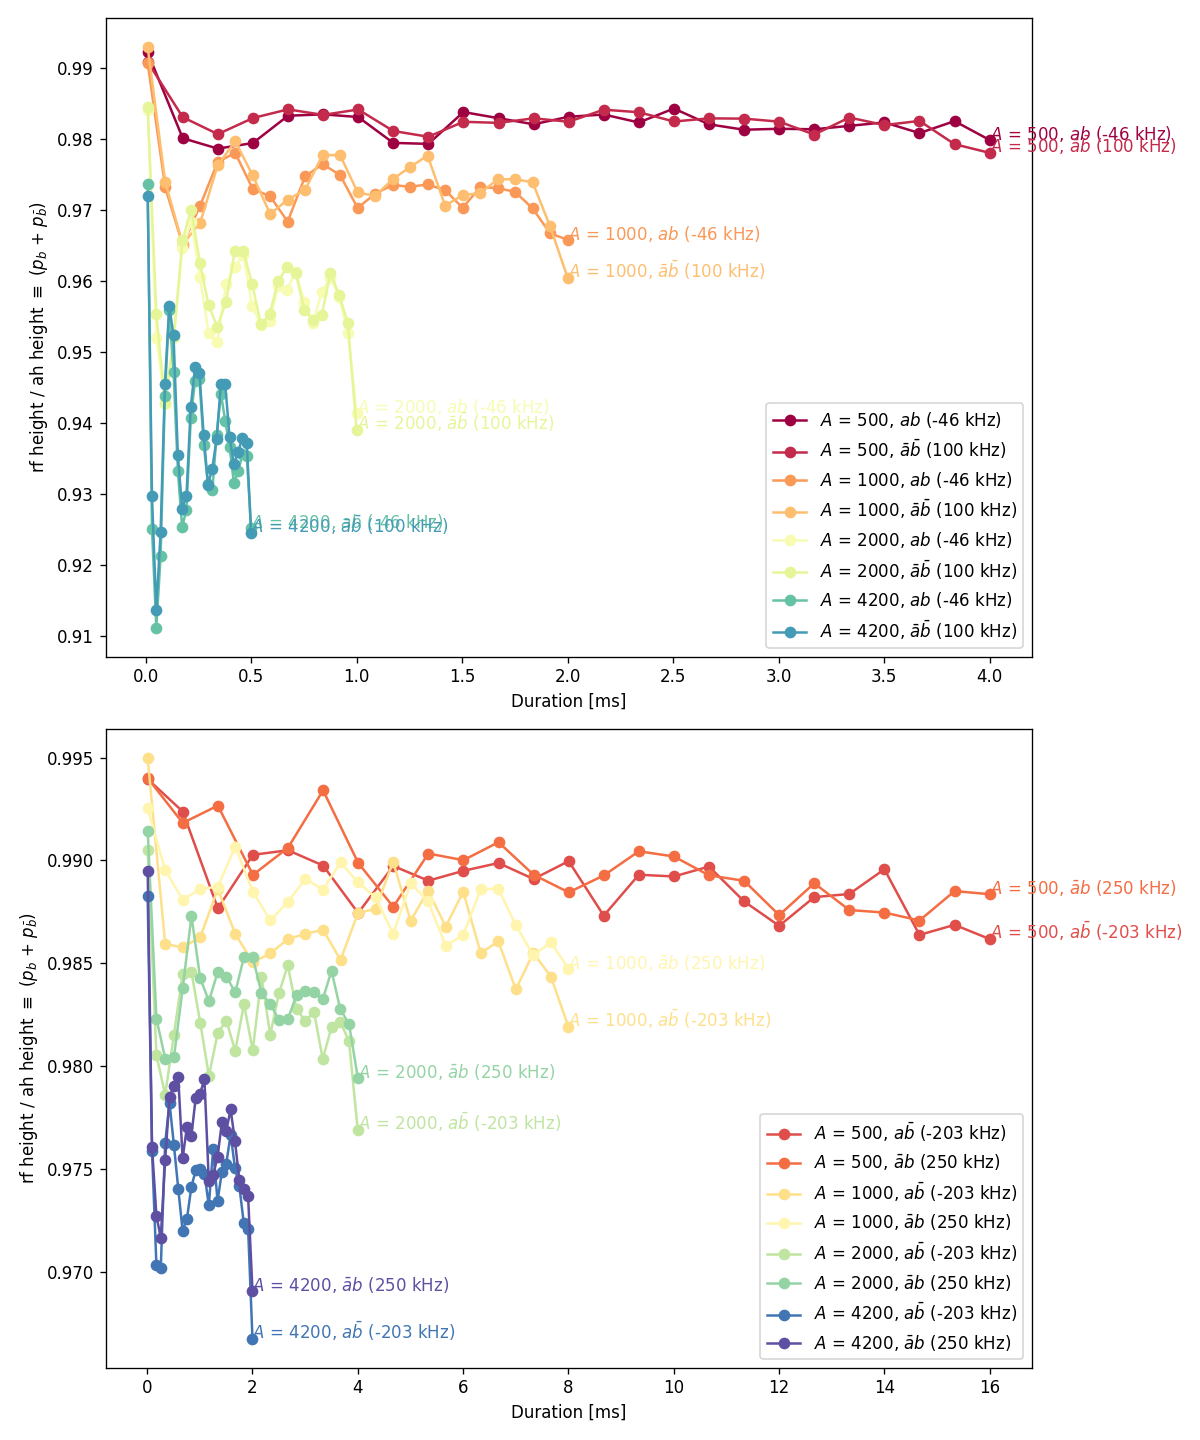

In [101]:
rf_amplitudes = [500, 1000, 2000, 4200]
rf_offsets = np.array([-46, 100, -203, 250])
rf_offset_labs = [r"$ab$", r"$\bar{a}\bar{b}$", r"$a\bar{b}$", r"$\bar{a}b$"]

all_data = [52547, 54546]
num_per_set = 25

cmap = colormaps.get_cmap('Spectral')
colors = cmap(np.linspace(0, 1, (all_data[1] - all_data[0]+1) // num_per_set // 5))

data = {}
counter = all_data[0]

for kk in range(len(rf_amplitudes)):
    for ll in range(len(rf_offsets)):
        data[fr"$A$ = {rf_amplitudes[kk]}, {rf_offset_labs[ll]} ({rf_offsets[ll]} kHz)"] = [counter, counter + num_per_set - 1]
        counter += num_per_set

fig, axs = plt.subplots(2, 1, figsize = (10, 12), dpi = 120)

for kk, (label, data_range) in enumerate(data.items()):
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_flopping(data_list)
    if "$ab$" in label or r"$\bar{a}\bar{b}$" in label:
        ax = 0
    else:
        ax = 1
    axs[ax].plot(xs, ys, 'o-', color = colors[kk], label = label)
    axs[ax].text(xs[0], ys[0], label, color = colors[kk])
    

for ax in axs:
    ax.set_xlabel("Duration [ms]")
    ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
    ax.legend()
    
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


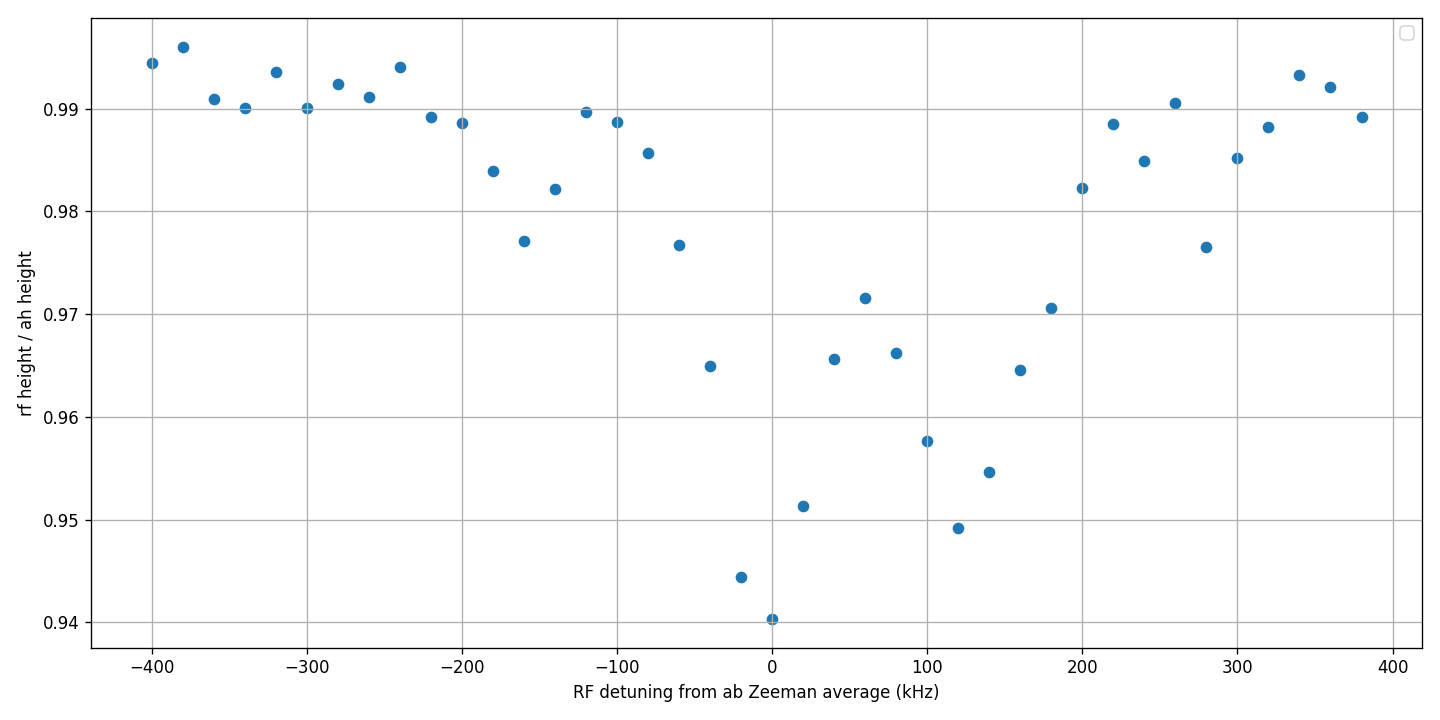

In [103]:
# data_list = range(3599, 3718)

data = {
    "": (103063, 103102),
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
markers = ['o', 'x', '*']
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    xs, ys = rf_spectroscopy(data_list)
    marker = markers[ll//10]
    ax.scatter(xs, ys, label=label, marker=marker)#, color=f"C{ll%3}", marker=markers[ll//3])
    
ax.set_xlabel("RF detuning from ab Zeeman average (kHz)")
ax.set_ylabel("rf height / ah height")# $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

f_0 = 0.03(4)
a = 0.0207(15)
sigma = 0.52(5)
b = 0.0002(3)
c = 0.9382(6)
Reduced chi-square is undefined.
f_0 = -0.04(7)
a = 0.060(7)
sigma = -0.49(7)
b = -0.0001(13)
c = 0.821(3)
Reduced chi-square is undefined.


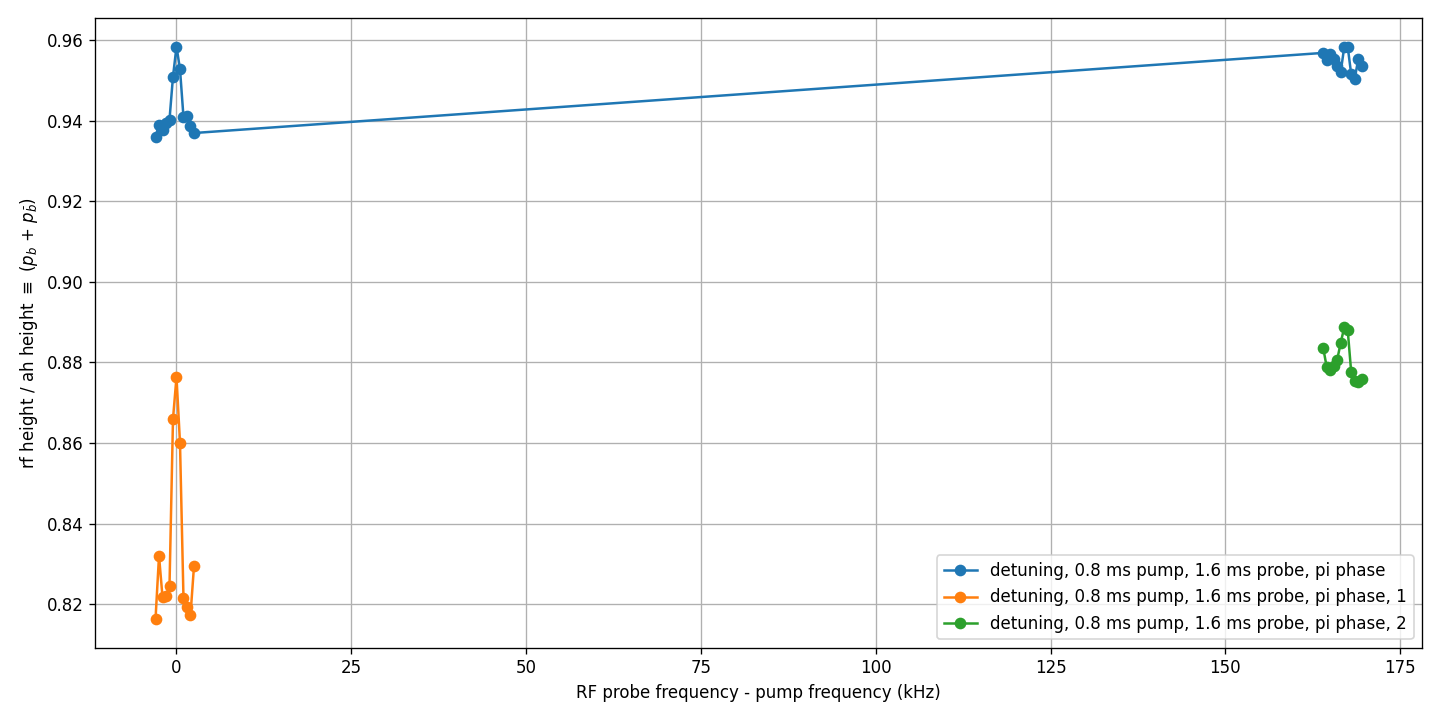

In [49]:
data = {
    #"phase = $0$": [100837, 100844],
    #"phase = $\\pi/4$": [100845, 100852],
    #"phase = $\\pi/2$": [100853, 100860],
    #"phase = $\\pi$": [100861, 100868],
    #"0.2 ms pump, pi phase": [100875, 100908],
    #"0.4 ms pump, abar->bbar": [100931, 100980],
    #"0.4 ms pump, a->bbar": [100981, 101030],
    #"0.4 ms pump, abar->b": [101081, 101130],
    #"0.2 ms pump": [101185, 101334],
    #"0.2 ms pump, a->bbar": [100981, 101030],
    #"0.2 ms pump, abar->b": [101081, 101130],
    #"0.2 ms pump, pi phase": [101338, 101427],
    #"0.05 ms pump, 0 phase": [101428, 101508],
    #"0.05 ms pump, pi/4 phase": [101509, 101589],
    #"0.05 ms pump, pi/2 phase": [101590, 101670],
    #"0.05 ms pump, pi phase": [101671, 101751],
    #"0.05 ms pump, pi phase, wavemeter to 650": [101795, 101854],
    #"0.05 ms pump, 0 phase, wavemeter to 650": [101855, 101884],
    #"0.05 ms pump, 0 phase, rf prep": [101894, 101923],
    #"0.05 ms pump, pi phase, rf prep": [101924, 101953],
    #"0.1 ms pump, 0.2 ms probe, pi phase": [101954, 101975],
    #"0.2 ms pump, 0.2 ms probe, pi phase": [102003, 102026],
    #"0.2 ms pump cross, 0.2 ms probe, pi phase": [102027, 102050],
    #"0.4 ms pump cross, 0.8 ms probe, pi phase": [102051, 102090],
    #"0.8 ms pump cross, 1.6 ms probe, pi phase": [102091, 102114],
    "detuning, 0.8 ms pump, 1.6 ms probe, pi phase": [102117, 102140],
    "detuning, 0.8 ms pump, 1.6 ms probe, pi phase, 1": [102141, 102152],
    "detuning, 0.8 ms pump, 1.6 ms probe, pi phase, 2": [102153, 102164],
    #"-80 to 0 kHz, 4 kHz step, 1.6 ms pump and probe, pi phase": [102534, 102608],
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, pi phase, 0.1 ms wait": [102609, 102668],  #102609
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, pi phase, 1.0 ms wait": [102669, 102728],  #102669
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, pi phase, 2.0 ms wait": [102729, 102748],
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, pi phase, 0.2 ms wait": [102749, 102768],
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, 0 phase, 1.0 ms wait": [102769, 102788],
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, pi/2 phase, 1.0 ms wait": [102789, 102800],
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, pi/2 phase, 1.0 ms wait, again": [102801, 102812],
    #"-90 to 10 kHz, 8 kHz step, 0.8 ms pump and probe, pi/2 phase, 1.0 ms wait, again 2": [102813, 102816],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)

    #xs, pos_ys, neg_ys = rf_spectroscopy_field(data_list)
    #ax.plot(xs, pos_ys, "o-", label = label + " $\\mathcal{N}=+1$")
    #ax.plot(xs, neg_ys, "o-", label = label + " $\\mathcal{N}=-1$")
    xs, ys = rf_spectroscopy(data_list)
    ax.plot(xs, ys, "o-", label = label)
    mask = np.abs(xs - 0) < 50
    try:
        pos_fitter = get_gaussian_fit(xs[mask], ys[mask], p0={"f_0": 0})
        # pos_fitter.set_bounds("b", -1e-12, 1e-12)
        pos_fitter.set_p0({"b": 0})
        pos_fitter.fit()
        xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
        #ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
        #ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
        #ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
        #fitters_left[label] = pos_fitter
        print(pos_fitter.all_results_str())
    except Exception:
        pass

#ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_xlabel("RF probe frequency - pump frequency (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

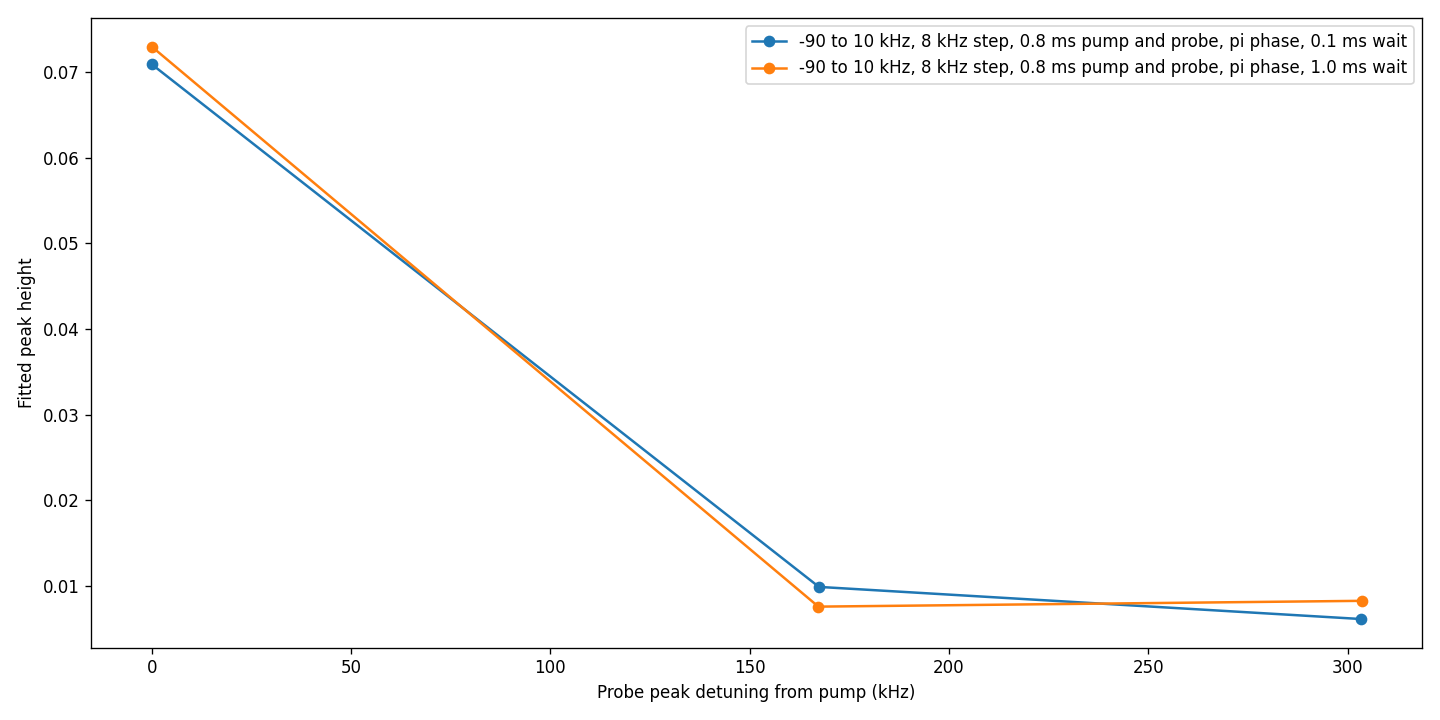

In [45]:
labels = list(fitters_right.keys())
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for label in labels:
    detunings = []
    ys = []
    for fitter in [fitters_left[label], fitters_middle[label], fitters_right[label]]:
        detunings.append(fitter.results["f_0"])
        ys.append(abs(fitter.results["a"]))
    ax.plot(detunings, ys, "-o", label=label)
ax.legend()
ax.set_xlabel("Probe peak detuning from pump (kHz)")
ax.set_ylabel("Fitted peak height")
plt.tight_layout()
plt.show()

ValueError: `ydata` must not be empty!

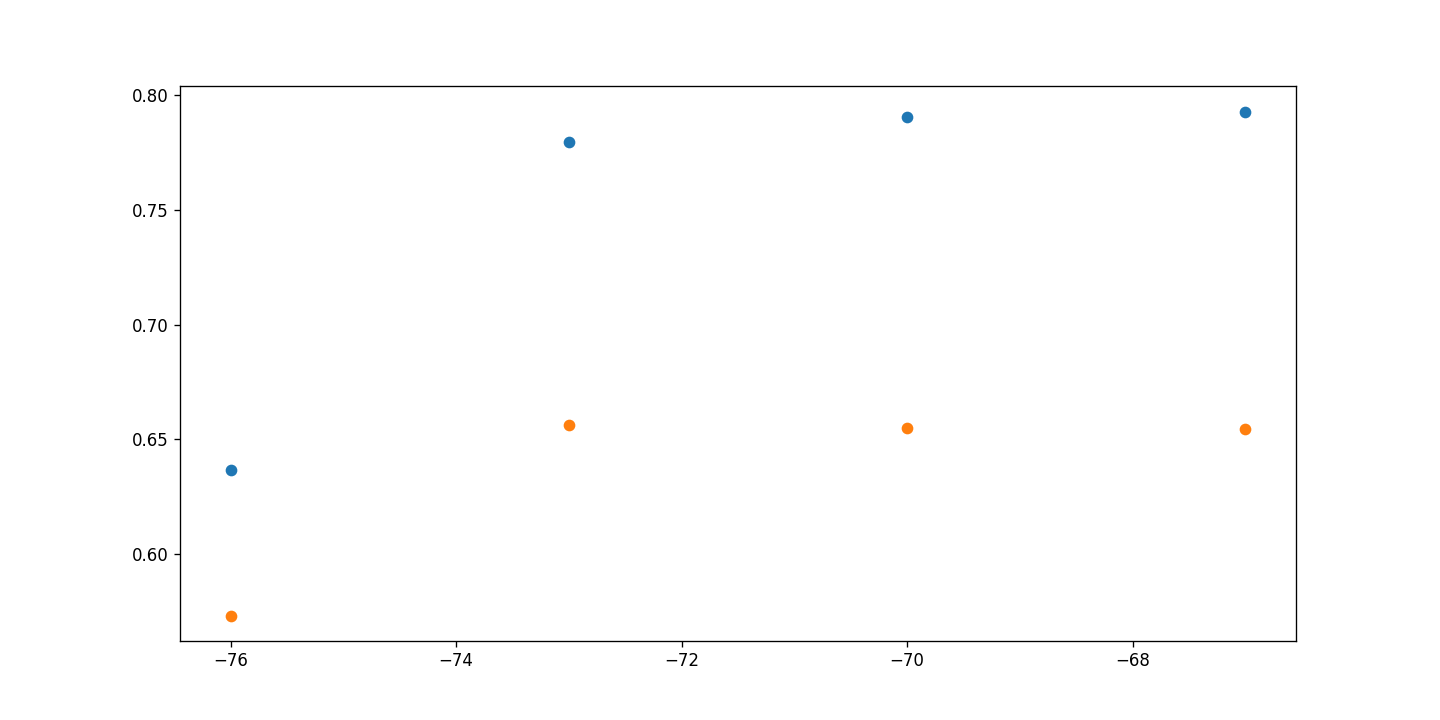

In [129]:
data = {
    "test": [100675, 100678],
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)


heights_1 = {}
f_1 = {}
heights_2 = {}
f_2 = {}
heights_3 = {}
f_3 = {}

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    # xs, pos_ys, neg_ys = rf_spectroscopy_field(data_list)

    all_xs, all_pos_ys, all_neg_ys = rf_spectroscopy_field(data_list)

    xs = []
    pos_ys = []
    neg_ys = []
    
    for rf_offset in set(all_xs):
        mask = all_xs == rf_offset
        xs.append(rf_offset)
        pos_ys.append(np.average(all_pos_ys[mask]))
        neg_ys.append(np.average(all_neg_ys[mask]))

    xs = np.array(xs)
    pos_ys = np.array(pos_ys)
    neg_ys = np.array(neg_ys)
    
    ax.scatter(xs, pos_ys, label = label + " $\\mathcal{N}=+1$")
    ax.scatter(xs, neg_ys, label = label + " $\\mathcal{N}=-1$")

    mask = xs < -150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": -209})
    pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": -209})
    neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    heights_1[label] = [pos_fitter.results["a"], neg_fitter.results["a"]]
    f_1[label] = [pos_fitter.results["f_0"], neg_fitter.results["f_0"]]
    
    mask = abs(xs) < 150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": np.average(xs[mask]), "sigma": 2})
    # pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": np.average(xs[mask]), "sigma": 2})
    # neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    heights_2[label] = [pos_fitter.results["a"], neg_fitter.results["a"]]
    f_2[label] = [pos_fitter.results["f_0"], neg_fitter.results["f_0"]]
    
    mask = xs > 200
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": 258, "sigma": 2, "c": 0.9})
    # pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": 258, "sigma": 2, "c": 0.9})
    # neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    heights_3[label] = [pos_fitter.results["a"], neg_fitter.results["a"]]
    f_3[label] = [pos_fitter.results["f_0"], neg_fitter.results["f_0"]]

ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

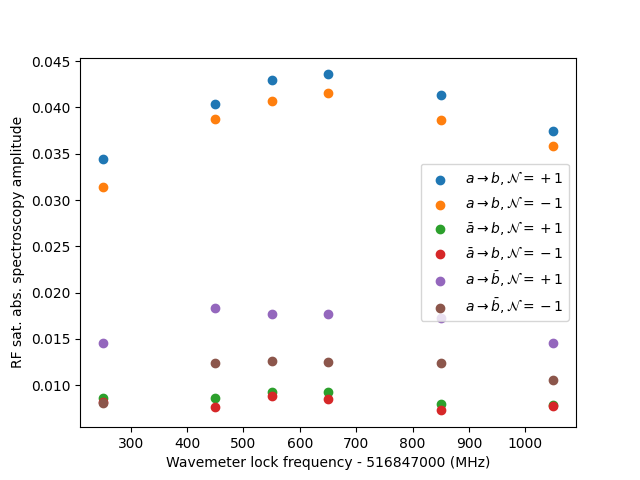

In [52]:
fig, ax = plt.subplots()
ax.scatter([float(kk) for kk in heights_2.keys()], [kk[0] for kk in heights_2.values()], label="$a\\to b, \\mathcal{N} = +1$")
ax.scatter([float(kk) for kk in heights_2.keys()], [kk[1] for kk in heights_2.values()], label="$a\\to b, \\mathcal{N} = -1$")
ax.scatter([float(kk) for kk in heights_1.keys()], [kk[0] for kk in heights_3.values()], label="$\\bar{a}\\to b, \\mathcal{N} = +1$")
ax.scatter([float(kk) for kk in heights_1.keys()], [kk[1] for kk in heights_3.values()], label="$\\bar{a}\\to b, \\mathcal{N} = -1$")
ax.scatter([float(kk) for kk in heights_3.keys()], [kk[0] for kk in heights_1.values()], label="$a\\to \\bar{b}, \\mathcal{N} = +1$")
ax.scatter([float(kk) for kk in heights_3.keys()], [kk[1] for kk in heights_1.values()], label="$a\\to \\bar{b}, \\mathcal{N} = -1$")
ax.set_xlabel("Wavemeter lock frequency - 516847000 (MHz)")
ax.set_ylabel("RF sat. abs. spectroscopy amplitude")
ax.legend()
plt.show()

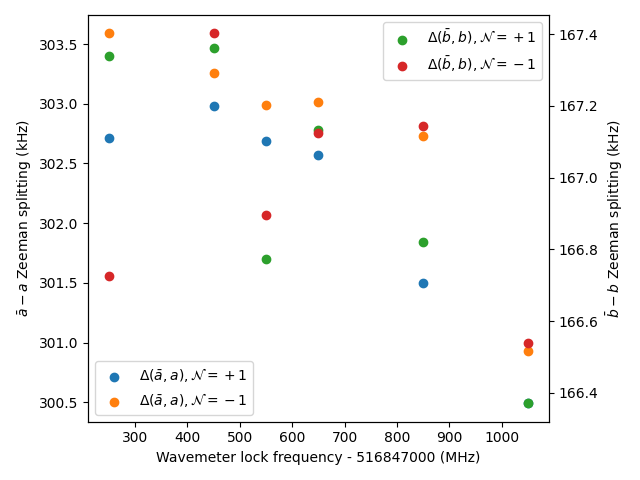

In [54]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.scatter([float(kk) for kk in f_2.keys()], np.array([kk[0] for kk in f_3.values()]) - np.array([kk[0] for kk in f_2.values()]), label="$\\Delta(\\bar{a}, a), \\mathcal{N} = +1$")
ax.scatter([float(kk) for kk in f_2.keys()], np.array([kk[1] for kk in f_3.values()]) - np.array([kk[1] for kk in f_2.values()]), label="$\\Delta(\\bar{a}, a), \\mathcal{N} = -1$")
ax1.scatter([float(kk) for kk in f_2.keys()], np.array([kk[0] for kk in f_2.values()]) - np.array([kk[0] for kk in f_1.values()]), label="$\\Delta(\\bar{b}, b), \\mathcal{N} = +1$", color="C2")
ax1.scatter([float(kk) for kk in f_2.keys()], np.array([kk[1] for kk in f_2.values()]) - np.array([kk[1] for kk in f_1.values()]), label="$\\Delta(\\bar{b}, b), \\mathcal{N} = -1$", color="C3")
ax.set_xlabel("Wavemeter lock frequency - 516847000 (MHz)")
ax1.set_ylabel("$\\bar{b} - b$ Zeeman splitting (kHz)")
ax.set_ylabel("$\\bar{a} - a$ Zeeman splitting (kHz)")
ax.legend(loc=3)
ax1.legend(loc=1)
plt.tight_layout()
plt.show()

In [53]:
headers["params"]["rf"]

{'name': 'rf_coil',
 'transition': 'ab',
 'pump_amplitude': 1000,
 'probe_amplitude': 500,
 'pump_offsets': array([-187, -181, -175, -169, -163, -157, -151]) <Unit('kilohertz')>,
 'probe_offset': -3.0 <Unit('kilohertz')>,
 'pump_time': 0.8 <Unit('millisecond')>,
 'probe_time': 1.6 <Unit('millisecond')>,
 'delay_time': 0.1 <Unit('millisecond')>,
 'probe_phase': 3.141592653589793}

In [55]:
headers["params"]["rf"]

{'name': 'rf_coil',
 'transition': 'ab',
 'pump_amplitude': 1000,
 'probe_amplitude': 500,
 'pump_offsets': array([-232, -228, -224, -220, -216, -212, -208, -204, -200, -196, -192,
        -188, -184]) <Unit('kilohertz')>,
 'probe_offset': -3.0 <Unit('kilohertz')>,
 'pump_time': 0.8 <Unit('millisecond')>,
 'probe_time': 1.6 <Unit('millisecond')>,
 'delay_time': 0.1 <Unit('millisecond')>,
 'probe_phase': 3.141592653589793}

In [99]:
data, headers = get_experiment_data(103098)

In [100]:
detunings_MHz = headers["detunings"].to("MHz").magnitude
transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])

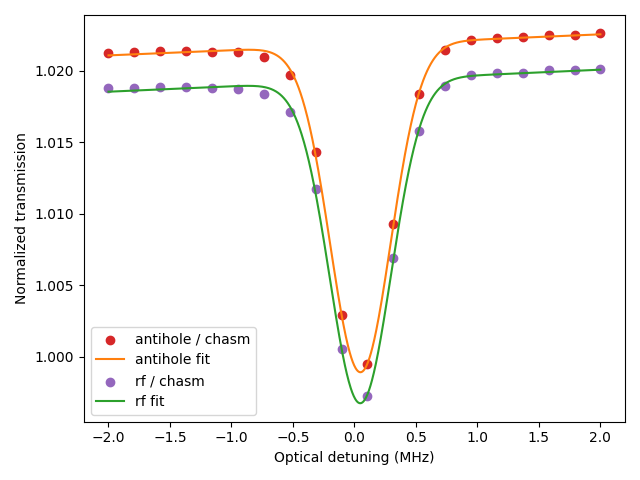

f_0 = 0.049(2)
a = -0.02291(18)
sigma = 0.246(2)
b = 0.00037(4)
c = 1.02182(6)
Reduced chi-square is undefined.



In [101]:
plt_monitor = False
use_positive = None

chasm_avg = transmissions_avg["chasm"]
antihole_avg = transmissions_avg["antihole"]
rf_avg = transmissions_avg["rf"]

if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
#ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
#ax.scatter(detunings_MHz, monitor_antihole_avg, label="antihole monitor", color="C2")
#ax.scatter(detunings_MHz, rf_avg, label="rf", color="C2")

#ax.scatter(detunings_MHz, antihole_normalized, label="antihole / monitor", color="C1")
ax.scatter(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], label="antihole / chasm", color="C3")
antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

#ax.scatter(detunings_MHz, rf_normalized / 5.7, label="rf / monitor", color="C2")
ax.scatter(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], label="rf / chasm", color="C4")
#ax.scatter(detunings_MHz[mask], rf_avg[mask]/antihole_avg[mask], label="rf / antihole")
#ax.scatter(detunings_MHz, monitor_rf_avg, label="rf monitor", color="C3")
#ax.scatter(detunings_MHz, rf_avg, label="rf avg", color="C4")
rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.all_results_str())
print()
#print(rf_fit.all_results_str())

/tmp/ipykernel_25590/1137749572.py:31: RuntimeWarning: invalid value encountered in divide
  return a*v/(np.abs(np.max(v))) + c


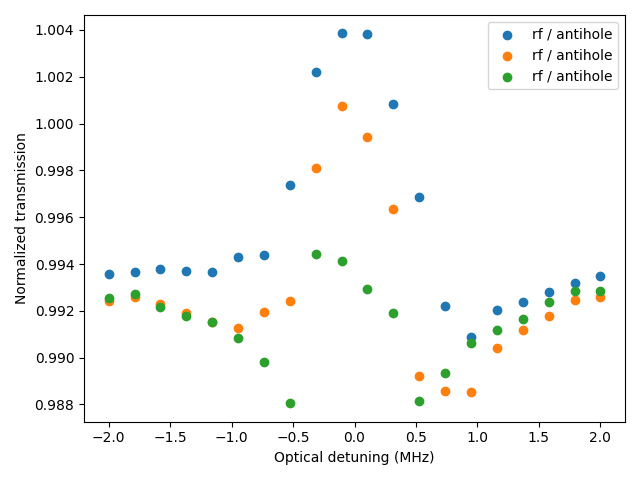

f0 = 0.011(3)
a = -0.1080(13)
sigma = 0.259(13)
gamma = 0.06(2)
c = 1.0422(6)
Reduced chi-square is undefined.

f0 = 0.016(4)
a = -0.1082(16)
sigma = 0.214(18)
gamma = 0.16(3)
c = 1.0372(8)
Reduced chi-square is undefined.


In [90]:
datas = [55399, 55400, 55401]

fig, ax = plt.subplots()

for kk in datas:
    data, headers = get_experiment_data(kk)
    (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
    detunings_MHz = headers["detunings"].to("MHz").magnitude
    plt_monitor = False
    use_positive = None

    chasm_normalized = chasm_avg / monitor_chasm_avg
    antihole_normalized = antihole_avg/monitor_antihole_avg
    #antihole_normalized = antihole_avg/monitor_antihole_avg
    rf_normalized = rf_avg/monitor_antihole_avg
    #rf_normalized = rf_avg/monitor_rf_avg
    
    
    if use_positive == True:
        mask = detunings_MHz > 0
    elif use_positive == False:
        mask = detunings_MHz < 0
    else:
        mask = detunings_MHz < 1e13
    #ax.scatter(detunings_MHz, chasm_avg / monitor_chasm_avg, label="chasm", color="C0")
    #ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
    #ax.scatter(detunings_MHz, monitor_antihole_avg, label="antihole monitor", color="C2")
    #ax.scatter(detunings_MHz, rf_avg, label="rf", color="C2")
    
    #ax.scatter(detunings_MHz, antihole_normalized, label="antihole / monitor", color="C1")
    #ax.scatter(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], label="antihole / chasm")
    antihole_fit_v = get_voigt_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask])
    antihole_fit_g = get_gaussian_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
    xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
    #ax.plot(xaxis, antihole_fit_v.fitted_value(xaxis), label = "antihole fit v")
    #ax.plot(xaxis, antihole_fit_g.fitted_value(xaxis), label = "antihole fit g")
    
    if "rf_repeats" in headers["params"]["detect"]:
        #ax.scatter(detunings_MHz, rf_normalized, label="rf / monitor", color="C2")
        #ax.scatter(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], label="rf / chasm")
        ax.scatter(detunings_MHz[mask], rf_avg[mask]/monitor_rf_avg[mask]/(antihole_avg[mask]/monitor_antihole_avg[mask]), label="rf / antihole")
        #ax.scatter(detunings_MHz[mask], rf_avg[mask]/(antihole_avg[mask]), label="rf / antihole")
        #ax.scatter(detunings_MHz, monitor_rf_avg, label="rf monitor", color="C3")
        #ax.scatter(detunings_MHz, rf_avg, label="rf avg", color="C4")
        rf_fit_v = get_voigt_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask])
        rf_fit_g = get_gaussian_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask]) + 0.001})
        #ax.plot(xaxis, rf_fit_v.fitted_value(xaxis), label = 'rf fit v')
        #ax.plot(xaxis, rf_fit_g.fitted_value(xaxis), label = 'rf fit g')
        pass
                
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit_v.all_results_str())
print()
print(rf_fit_v.all_results_str())

In [1249]:
def temporal_drift(data_list, use_monitor=True, use_positive=None):
    chasm_voltages = []
    antihole_offsets = []
    antihole_amplitudes = []
    antihole_f0s = []
    antihole_slopes = []
    antihole_gammas = []
    rf_offsets = []
    rf_amplitudes = []
    rf_f0s = []
    rf_slopes = []
    rf_gammas = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        if use_positive == True:
            mask = detunings > 0
        elif use_positive == False:
            mask = detunings < 0
        else:
            mask = detunings < 1e13
        chasm_voltages.append(np.average(chasm_avg))
        if use_monitor:
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_avg[mask]/monitor_antihole_avg[mask], p0={"f_0": np.average(detunings[mask])})
        else:
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings[mask])})
        antihole_amplitudes.append(antihole_fit.results["a"])
        #antihole_slopes.append(antihole_fit.results["b"])
        antihole_offsets.append(antihole_fit.results["c"])
        antihole_gammas.append(antihole_fit.results["sigma"])
        antihole_f0s.append(antihole_fit.results["f_0"])
        
        if use_monitor:
            rf_fit = get_gaussian_fit(detunings[mask], rf_avg[mask]/monitor_rf_avg[mask], p0={"f_0": np.average(detunings[mask])})
        else:
            rf_fit = get_gaussian_fit(detunings[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings[mask])})
        rf_amplitudes.append(rf_fit.results["a"])
        #rf_slopes.append(rf_fit.results["b"])
        rf_offsets.append(rf_fit.results["c"])
        rf_gammas.append(rf_fit.results["sigma"])
        rf_f0s.append(rf_fit.results["f_0"])

    return (
        np.array(chasm_voltages),
        np.array(antihole_offsets),
        np.array(antihole_amplitudes),
        np.array(antihole_f0s),
        np.array(antihole_slopes),
        np.array(antihole_gammas),
        np.array(rf_offsets),
        np.array(rf_amplitudes),
        np.array(rf_f0s),
        np.array(rf_slopes),
        np.array(rf_gammas),
    )

In [644]:
data_numbers = np.array(list(range(25136, 26222)))  # no field plate
data_numbers = np.array(list(range(26265, 27203)))  # field plate
data_numbers = np.array(list(range(27204, 27446)))  # field plate reversed Stark shift

a = -0.000005(3)
b = 0.9891(5)
Reduced chi-square is undefined.
f0 = 0.9885(2)
a = 30.4(1.7)
sigma = 0.0036(2)
Reduced chi-square is undefined.
a = -0.000006(4)
b = 0.9893(5)
Reduced chi-square is undefined.
f0 = 0.98883(19)
a = 27.7(1.2)
sigma = -0.00382(19)
Reduced chi-square is undefined.


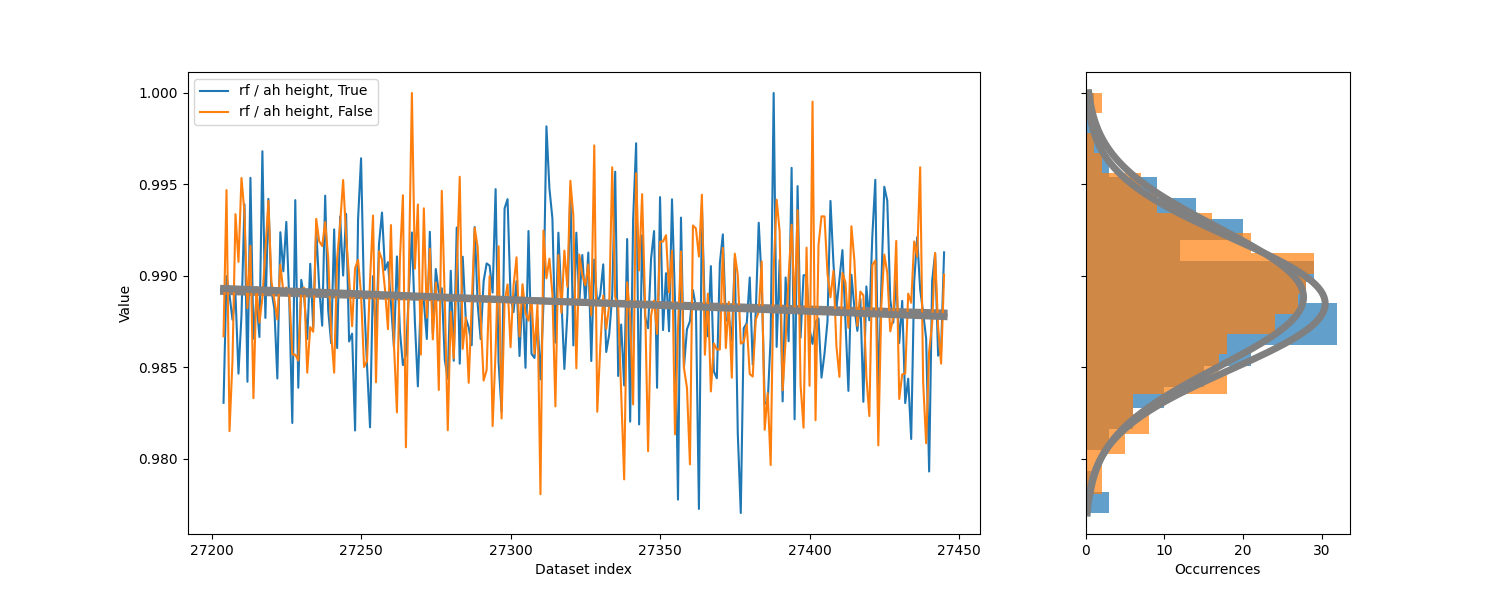

In [645]:
fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], figsize=(15, 6), sharey=True)

ys = {}
xs = {}
for polarity in [True, False]:

    chasm_voltages, antihole_offsets, antihole_amplitudes, antihole_f0s, antihole_slopes, antihole_gammas, rf_offsets, rf_amplitudes, rf_f0s, rf_slopes, rf_gammas = temporal_drift(
        data_numbers, use_monitor=False, use_positive=polarity
    )
    rf_ah_height_ratio = rf_amplitudes / antihole_amplitudes / max(rf_amplitudes / antihole_amplitudes)
    axs[0].plot(data_numbers, rf_ah_height_ratio, label=f"rf / ah height, {polarity}")
    axs[0].set_xlabel("Dataset index")
    axs[0].set_ylabel("Value")
    axs[0].grid()
    axs[0].legend()
    
    fitter_linear = Fitter(linear)
    fitter_linear.set_absolute_sigma(False)
    fitter_linear.set_data(data_numbers - data_numbers[0], rf_ah_height_ratio)
    fitter_linear.fit()
    print(fitter_linear.all_results_str())
    axs[0].plot(data_numbers, fitter_linear.fitted_value(data_numbers - data_numbers[0]), color="gray", linewidth=5)
    
    
    hist, bin_edges = np.histogram(rf_ah_height_ratio, bins=20)
    bin_size = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_size / 2
    axs[1].barh(bin_centers, hist, height=bin_size, alpha=0.7)
    ys[polarity] = hist
    xs[polarity] = bin_centers
    
    plt_values = np.linspace(min(rf_ah_height_ratio), max(rf_ah_height_ratio), 200)
    fitter = Fitter(gaussian0)
    fitter.set_absolute_sigma(False)
    fitter.set_data(bin_centers, hist)
    fitter.set_p0({"f0": 0.99, "a": 1, "sigma": 1e-2})
    fitter.fit()
    axs[1].plot(fitter.fitted_value(plt_values), plt_values, color="gray", linewidth=5)
    axs[1].set_xlabel("Occurrences")
    print(fitter.all_results_str())
plt.show()

In [568]:


# 